# 机器翻译与数据集
:label:`sec_machine_translation`

我们已经使用循环神经网络来设计语言模型，这是自然语言处理的关键。另一个最佳的基准测试是“机器翻译”，这是将输入序列转换成输出序列的序列转换模型的的核心问题。序列转换模型在各种现代人工智能应用中发挥着至关重要的作用，将成为本章剩余部分和 :numref:`chap_attention` 的重点。为此，本节介绍机器翻译问题及其稍后将使用的数据集。

*机器翻译*（machine translation）指的是将序列从一种语言自动翻译成另一种语言。事实上，这个领域可以追溯到数字计算机发明后不久的20世纪40年代，特别是在第二次世界大战中使用计算机破解语言编码。几十年来，在使用神经网络进行端到端学习的兴起之前，统计学方法在这一领域一直占据主导地位 :cite:`Brown.Cocke.Della-Pietra.ea.1988,Brown.Cocke.Della-Pietra.ea.1990` 。因为 *统计机器翻译*（statistical machine translation）涉及了翻译模型和语言模型等组成部分的统计分析，因此基于神经网络的方法通常被称为 *神经机器翻译*（neural machine translation），用于将两种翻译模型区分开来。

这本书强调端到端的学习，其重点放在神经机器翻译方法上。与 :numref:`sec_language_model` 中的语言模型问题（语料库是单一语言的）不同，机器翻译数据集是由源语言和目标语言的文本序列对组成的。因此，我们需要一种不同的方法来预处理机器翻译数据集，而不是复用语言模型的预处理程序。在下面，我们将展示如何将预处理后的数据加载到小批量中进行训练。


In [1]:
import os
import tensorflow as tf
from d2l import tensorflow as d2l

## 下载和预处理数据集

首先，我们下载一个由[Tatoeba项目的双语句子对](http://www.manythings.org/anki/)组成的英－法数据集。数据集中的每一行都是一对制表符分隔的英文文本序列和翻译后的法语文本序列。请注意，每个文本序列可以是一个句子，也可以是包含多个句子的一个段落。在这个将英语翻译成法语的机器翻译问题中，英语是 *源语言*（source language），法语是 *目标语言*（target language）。


In [2]:
#@save
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

#@save
def read_data_nmt():
    """载入“英语－法语”数据集。"""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



下载数据集后，经过几个预处理步骤，我们对原始的文本数据进行处理。例如，我们用空格代替 *不间断空格*（non-breaking space），使用小写字母替换大写字母，并在单词和标点符号之间插入空格。


In [3]:
#@save
def preprocess_nmt(text):
    """预处理“英语－法语”数据集。"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [
        ' ' + char if i > 0 and no_space(char, text[i - 1]) else char
        for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


## 标记化

与 :numref:`sec_language_model` 中的字符级标记化不同，对于机器翻译，我们更喜欢单词级标记化（最先进的模型可能使用更高级的标记化技术）。下面的`tokenize_nmt`函数对前`num_examples`个文本序列对进行标记，其中每个标记要么是一个单词，要么是一个标点符号。此函数返回两个标记列表：`source`和`target`。具体地说，`source[i]`是源语言（这里是英语）第 $i$ 个文本序列的标记列表，`target[i]`指的是目标语言（这里是法语）的标记。


In [4]:
#@save
def tokenize_nmt(text, num_examples=None):
    """标记化“英语－法语”数据数据集。"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

让我们绘制每个文本序列所包含的标记数量的直方图。在这个简单的英法数据集中，大多数文本序列的标记数量少于20个。


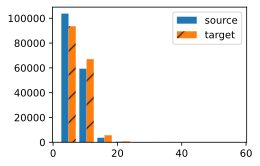

In [5]:
d2l.set_figsize()
_, _, patches = d2l.plt.hist([[len(l)
                               for l in source], [len(l) for l in target]],
                             label=['source', 'target'])
for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right');

## 词汇表

由于机器翻译数据集由语言对组成，因此我们可以分别为源语言和目标语言构建两个词汇表。使用单词级标记化时，词汇量将明显大于使用字符级标记化时的词汇量。为了缓解这一问题，这里我们将出现次数少于2次的低频率标记视为相同的未知（“&lt;unk&gt;”）标记。除此之外，我们还指定了额外的特定标记，例如在小批量时用于将序列填充到相同长度的填充标记（“&lt;pad&gt;”），以及序列的开始标记（“&lt;bos&gt;”）和结束标记（“&lt;eos&gt;”）。这些特殊标记在自然语言处理任务中比较常用。


In [6]:
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

## 加载数据集
:label:`subsec_mt_data_loading`

回想一下，在语言模型中，一个序列无论是只有一个句子的部分还是跨越了多个句子的范围，这个样本序列都有一个固定的长度。这个固定长度是由 :numref:`sec_language_model` 中的`num_steps`（时间步数或标记数）参数指定的。在机器翻译中，每个样本都是由源和目标组成的文本序列对，其中的每个文本序列可以具有不同的长度。

为了提高计算效率，我们仍然可以通过 *截断* 和 *填充* 方法实现一次只处理一小批量文本序列。假设同一小批量中的每个序列应该具有相同的长度`num_steps`。如果文本序列的标记数目少于`num_steps`个，我们将继续在其末尾添加特定的“&lt;pad&gt;”标记，直到其长度达到`num_steps`。反之，我们将截断文本序列，只取其前`num_steps`个标记，并且丢弃剩余的标记。这样，每个文本序列将具有相同的长度，以便以相同形状的小批量进行加载。

下面的`truncate_pad`函数如前所述地截断或填充文本序列。


In [7]:
#@save
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

现在我们定义一个函数，将文本序列转换成小批量用于训练。我们将特定的“&lt;eos&gt;”标记添加到每个序列的末尾，以表示序列的结束。当模型通过一个接一个地生成序列标记进行预测时，“&lt;eos&gt;”标记的生成可以说明输出序列是完成了的。此外，我们还记录了不包括填充标记的每个文本序列的长度，在稍后将要介绍的一些模型会需要此信息。


In [8]:
#@save
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量。"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = tf.constant([
        truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = tf.reduce_sum(tf.cast(array != vocab['<pad>'], tf.int32), 1)
    return array, valid_len

## 训练模型

最后，我们定义`load_data_nmt`函数来返回数据迭代器，以及源语言和目标语言的词汇表。


In [9]:
#@save
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词汇表。"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

让我们读出“英语－法语”数据集中的第一个小批量数据。


In [10]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', tf.cast(X, tf.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', tf.cast(Y, tf.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

X: tf.Tensor(
[[  6 146   8   4   3   1   1   1]
 [ 16  60   4   3   1   1   1   1]], shape=(2, 8), dtype=int32)
valid lengths for X: tf.Tensor([5 4], shape=(2,), dtype=int32)
Y: tf.Tensor(
[[  6  46 157   4   3   1   1   1]
 [ 41  53   4   3   1   1   1   1]], shape=(2, 8), dtype=int32)
valid lengths for Y: tf.Tensor([5 4], shape=(2,), dtype=int32)


## 小结

* 机器翻译是指将文本序列从一种语言自动翻译成另一种语言。
* 使用单词级标记化时的词汇量，将明显大于使用字符级标记化时的词汇量。为了缓解这一问题，我们可以将低频标记视为相同的未知标记。
* 通过截断和填充文本序列，以便所有的文本序列都具有相同的长度，方便以小批量方式加载。

## 练习

1. 在`load_data_nmt`函数中尝试`num_examples`参数的不同值。这对源语言和目标语言的词汇量有何影响？
1. 某些语言（例如中文和日语）的文本没有单词边界指示符（例如，空格）。对于这种情况，单词级标记化仍然是个好主意吗？为什么？
